# Imports and system definition

In [19]:
import numpy as np
import scipy.linalg
import scipy.signal
import matplotlib.pyplot as plt

# State-space matrices from the combined model
A = np.array([
    [0, 1, 0],
    [-6.356, 0, 1.86],
    [6.35, 0, -33.2]
])

B = np.array([
    [0],
    [-2.49],
    [44.5]
])

C = np.array([
    [1, 0, 0],
    [0, 0, 1]
])

D = np.array([
    [0],
    [0]
])

# Create the continuous-time state-space system
system = scipy.signal.StateSpace(A, B, C, D)

print("State-space model defined successfully!")
print("\nA =\n", A)
print("\nB =\n", B)
print("\nC =\n", C)
print("\nD =\n", D)

State-space model defined successfully!

A =
 [[  0.      1.      0.   ]
 [ -6.356   0.      1.86 ]
 [  6.35    0.    -33.2  ]]

B =
 [[ 0.  ]
 [-2.49]
 [44.5 ]]

C =
 [[1 0 0]
 [0 0 1]]

D =
 [[0]
 [0]]


# Controllability and Observability

- **Controllability**: A system is controllable if it is possible to move the system from any initial state to any desired final state in a finite time. We can check this by calculating the rank of the controllability matrix.
- **Observability**: A system is observable if it is possible to determine the internal state of the system by observing its outputs. We can check this by calculating the rank of the observability matrix.

In [20]:
# Controllability
ctrb_matrix = np.hstack([B, A @ B, A @ A @ B])
ctrb_rank = np.linalg.matrix_rank(ctrb_matrix)

print(f"Controllability Matrix Rank: {ctrb_rank}")
if ctrb_rank == A.shape[0]:
    print("The system is controllable. ✅")
else:
    print("The system is not controllable. ❌")

# Observability
obsv_matrix = np.vstack([C, C @ A, C @ A @ A])
obsv_rank = np.linalg.matrix_rank(obsv_matrix)

print(f"\nObservability Matrix Rank: {obsv_rank}")
if obsv_rank == A.shape[0]:
    print("The system is observable. ✅")
else:
    print("The system is not observable. ❌")

Controllability Matrix Rank: 3
The system is controllable. ✅

Observability Matrix Rank: 3
The system is observable. ✅


# LQR Design

## Discretization

In [21]:
# Discretize the system
dt_controller = 0.01  # Controller sample time
discrete_system = system.to_discrete(dt=dt_controller)
Ad = discrete_system.A
Bd = discrete_system.B

print("Discrete-time system matrices:")
print("\nAd =\n", Ad)
print("\nBd =\n", Bd)

Discrete-time system matrices:

Ad =
 [[ 9.99684032e-01  9.99894531e-03  8.35039108e-05]
 [-6.30230466e-02  9.99684032e-01  1.58257084e-02]
 [ 5.40286283e-02  2.85080556e-04  7.17488995e-01]]

Bd =
 [[-1.11771816e-04]
 [-2.11814498e-02]
 [ 3.78666862e-01]]


## Tunning

In [22]:
# LQR weighting matrices
Q = np.diag([10, 1, 1])  # Penalize angle error more
R = np.array([[0.1]])      # Penalize control input

# Solve the discrete-time Algebraic Riccati Equation (DARE)
P = scipy.linalg.solve_discrete_are(Ad, Bd, Q, R)

# Calculate the LQR gain
K = np.linalg.inv(R + Bd.T @ P @ Bd) @ (Bd.T @ P @ Ad)

print("LQR Gain (K):", K)

LQR Gain (K): [[-7.44990783 -0.09897606  1.20793109]]


# Closed Loop Simulation Without Disturbances

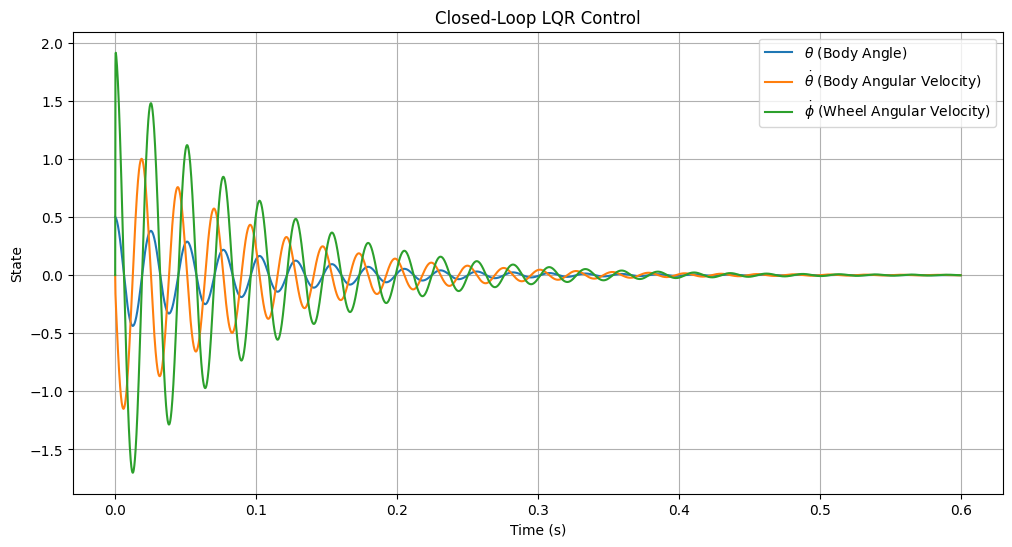

In [23]:
# Simulation parameters
T_sim = 0.6
dt = 0.0001  # Time step
t = np.arange(0, T_sim, dt)
x0 = np.array([0.5, 0, 0])  # Initial condition (small tilt)

# Simulation loop
x = x0
x_history = [x0]
for _ in t[1:]:
    u = -K @ x
    x = Ad @ x + Bd @ u.flatten()
    x_history.append(x)

x_history = np.array(x_history)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(t, x_history[:, 0], label='$\\theta$ (Body Angle)')
plt.plot(t, x_history[:, 1], label='$\\dot{\\theta}$ (Body Angular Velocity)')
plt.plot(t, x_history[:, 2], label='$\\dot{\\phi}$ (Wheel Angular Velocity)')
plt.title('Closed-Loop LQR Control')
plt.xlabel('Time (s)')
plt.ylabel('State')
plt.grid(True)
plt.legend()
plt.show()

# Closed Loop Simulation With Disturbances

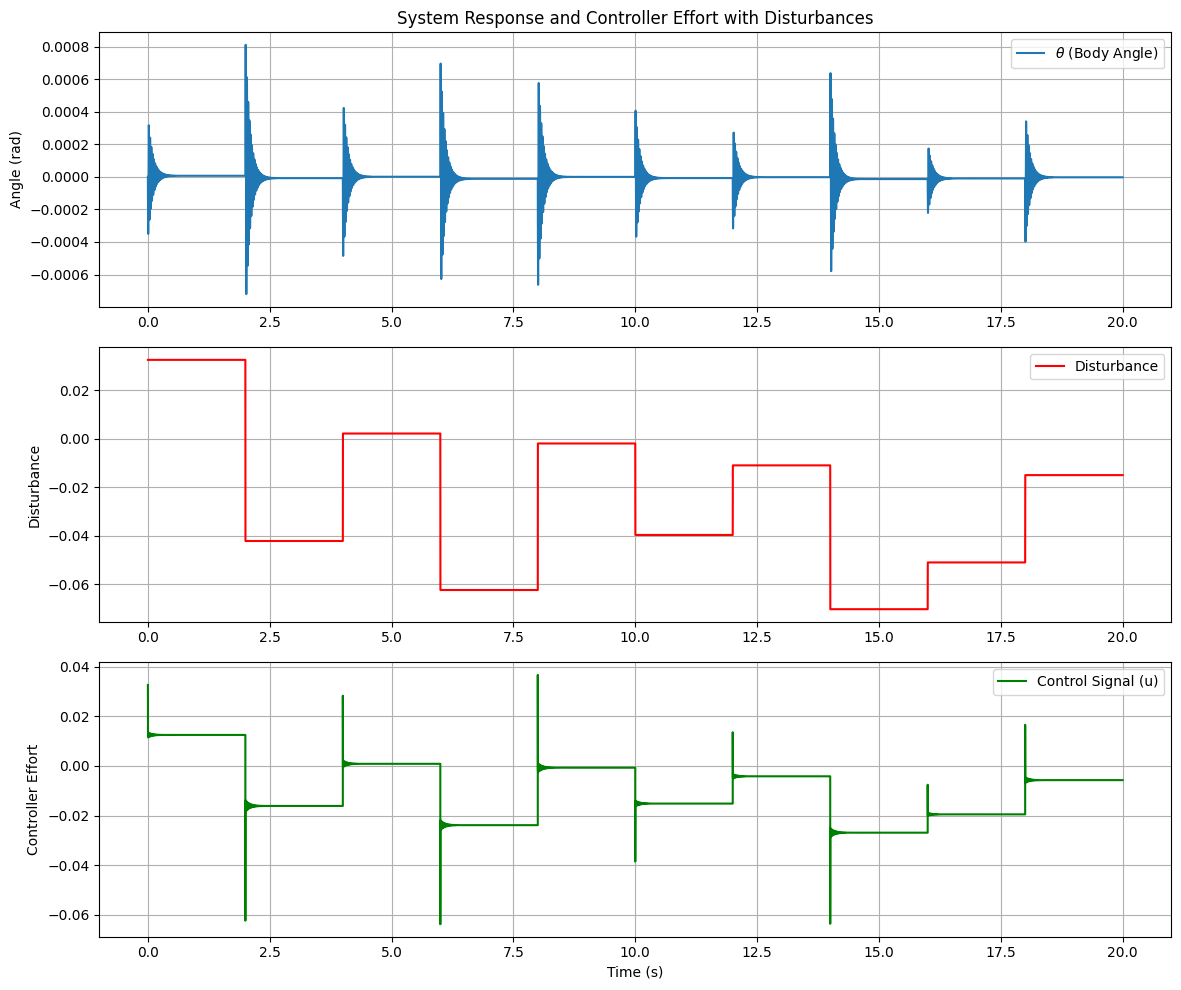

In [24]:
# --- Simulation parameters and disturbance generation ---
T_sim = 20
t = np.arange(0, T_sim, dt)
x0 = np.array([0.0, 0, 0]) # Start from a stable position

disturbance_magnitude = 0.04
disturbance_interval = 2.0 # seconds
num_samples_in_interval = int(disturbance_interval / dt)
num_disturbance_steps = int(np.ceil(T_sim / disturbance_interval))
random_steps = disturbance_magnitude * np.random.randn(num_disturbance_steps)
slow_disturbance = np.repeat(random_steps, num_samples_in_interval)
slow_disturbance = slow_disturbance[:len(t)]


# --- Simulation loop with control effort recording ---
x = x0
x_history = [x0]
u_history = []

for i, time in enumerate(t):
    # Calculate control signal
    u = -K @ x + slow_disturbance[i]

    # Store the control signal
    u_history.append(u)

    # Update the state
    if i < len(t) - 1: # Ensure we don't go past the end of the time array
        x = Ad @ x + Bd @ u.flatten()
        x_history.append(x)


x_history = np.array(x_history)
u_history = np.array(u_history).flatten() # Flatten for plotting


# --- Plot the results ---
plt.figure(figsize=(12, 10))

# Plot 1: Body Angle State
ax1 = plt.subplot(3, 1, 1)
ax1.plot(t, x_history[:, 0], label='$\\theta$ (Body Angle)')
ax1.set_title('System Response and Controller Effort with Disturbances')
ax1.set_ylabel('Angle (rad)')
ax1.grid(True)
ax1.legend()

# Plot 2: Disturbance Signal
ax2 = plt.subplot(3, 1, 2, sharex=ax1)
ax2.plot(t, slow_disturbance, 'r-', label='Disturbance')
ax2.set_ylabel('Disturbance')
ax2.grid(True)
ax2.legend()

# Plot 3: Controller Effort
ax3 = plt.subplot(3, 1, 3, sharex=ax1)
ax3.plot(t, u_history, 'g-', label='Control Signal (u)')
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Controller Effort')
ax3.grid(True)
ax3.legend()

plt.tight_layout()
plt.show()